# Section I: Looking at Demographics + Medical Charges

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("insurance.csv")

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,45,female,25.175,2,no,northeast,9095.06825
1,36,female,30.020,0,no,northwest,5272.17580
2,64,female,26.885,0,yes,northwest,29330.98315
3,46,male,25.745,3,no,northwest,9301.89355
4,19,male,31.920,0,yes,northwest,33750.29180


### Cleaning

In [4]:
df['sex'] = np.where(df['sex'] == 'male', 1, 0)
df['smoker'] = np.where(df['smoker'] == 'yes', 1, 0)
df['have_kids'] = np.where(df['children'] == 0,0 ,1)

In [5]:
del df['children']

In [6]:
df.head()

,age,sex,bmi,smoker,region,charges,have_kids
0,45,0,25.175,0,northeast,9095.06825,1
1,36,0,30.020,0,northwest,5272.17580,0
2,64,0,26.885,1,northwest,29330.98315,0
3,46,1,25.745,0,northwest,9301.89355,1
4,19,1,31.920,1,northwest,33750.29180,0


### 1. Read in Data and report summary statistics (mean + std / frequency) for age, sex, bmi, children, smoker, and charges) by region.

In [7]:
meandf = df.groupby("region").mean().round(2)
stddf = df.groupby('region').std().round(2)
stddf, meandf

(             age  sex   bmi  smoker   charges  have_kids
 region                                                  
 northeast  13.85  0.5  6.09    0.40  11126.07       0.50
 northwest  13.86  0.5  5.19    0.39  11329.23       0.49
 southeast  14.15  0.5  6.69    0.44  13933.80       0.50
 southwest  14.04  0.5  5.70    0.39  11592.10       0.49,
              age   sex    bmi  smoker   charges  have_kids
 region                                                    
 northeast  38.83  0.49  29.41    0.20  13387.63       0.55
 northwest  39.39  0.49  29.24    0.19  12609.90       0.60
 southeast  38.94  0.53  33.40    0.27  14952.59       0.55
 southwest  40.00  0.51  30.69    0.18  12530.71       0.59)

The "meandf" and "stddf" gives us the summary statistics.


### 3. In this sample, is female age different from male age?

In [9]:
mean_age = df.groupby("sex")['age'].mean()
mean_age

sex
0    40.004032
1    38.606299
Name: age, dtype: float64

The mean female age is higher than the mean meale age for this sample.

### 4. Is there a difference in smoking rates between those who have kids and those who do not?

In [10]:
smoker_kids = df.groupby(["have_kids","smoker"])['age'].count()
smoker_kids_p = smoker_kids.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).round(2)
smoker_kids_p 

have_kids  smoker
0          0         78.45
           1         21.55
1          0         79.03
           1         20.97
Name: age, dtype: float64

The "smoker_kids_p" gives us the percentage differnce in smoking rates based on the person having kids or not.

### 5. Is there a difference in smoking rates between regions?

In [11]:
reg_smoker = df.groupby(["region","smoker"])['age'].count()
reg_smoker_p = reg_smoker.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).round(2)
reg_smoker_p

region     smoker
northeast  0         79.56
           1         20.44
northwest  0         81.05
           1         18.95
southeast  0         73.19
           1         26.81
southwest  0         81.96
           1         18.04
Name: age, dtype: float64

The "reg_smoker_p" gives us the percentage differnce in smoking rates between regions.

### 6. Are there any instances of high collinearity in this data-set?

I have answered this question in the question 7. of the section

In [12]:
df1 = pd.get_dummies(df, columns=['region'], drop_first = True)

In [13]:
df1.head()

,age,sex,bmi,smoker,charges,have_kids,region_northwest,region_southeast,region_southwest
0,45,0,25.175,0,9095.06825,1,0,0,0
1,36,0,30.020,0,5272.17580,0,1,0,0
2,64,0,26.885,1,29330.98315,0,1,0,0
3,46,1,25.745,0,9301.89355,1,1,0,0
4,19,1,31.920,1,33750.29180,0,1,0,0


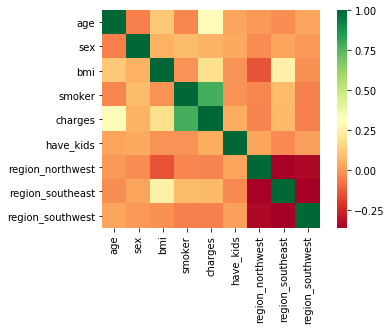

In [14]:
sns.heatmap(df1.corr(),square=True,cmap='RdYlGn')

As we can see from the graph above, there is high positive correlation between charges and smoker.

### 7. A coworker wants to know whether:
- being male affects medical cost
- being a smoker affects medical cost
- what is the effect of each additional year on medical cost

#### Build a model(s) to answer this. Please detail any assumptions you make / how you checked them.

In [15]:
# spliting the data into features and target set
X = df1.drop('charges', axis=1)
y = df1['charges'].values

In [16]:
# spliting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [17]:
scaler = StandardScaler()

In [18]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
scaled_features = scaler.transform(X_train)

In [20]:
# scaling the training features
scaled_XTR = pd.DataFrame(scaled_features,columns=X_train.columns[:])
scaled_XTR.head()

,age,sex,bmi,smoker,have_kids,region_northwest,region_southeast,region_southwest
0,-0.826105,-0.981491,0.340455,-0.514361,0.837419,-0.591253,1.632993,-0.579747
1,-1.538861,1.018858,-0.114740,-0.514361,-1.194145,-0.591253,1.632993,-0.579747
2,0.670683,-0.981491,-0.148959,-0.514361,-1.194145,1.691324,-0.612372,-0.579747
3,-1.538861,1.018858,-0.859604,-0.514361,-1.194145,-0.591253,-0.612372,-0.579747
4,-1.111207,1.018858,-0.164079,1.944161,-1.194145,-0.591253,-0.612372,-0.579747


In [21]:
# fitting Linear Regression
reg = linear_model.LinearRegression()
reg.fit(scaled_XTR, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
# Calculating R squared
r_sq = reg.score(scaled_XTR,y_train)
r_sq

0.7621031465717178

In [23]:
scaled_test= scaler.transform(X_test)

In [24]:
# scalimg the test features
scaled_XTS = pd.DataFrame(scaled_test,columns=X_test.columns[:])
scaled_XTS.head()

,age,sex,bmi,smoker,have_kids,region_northwest,region_southeast,region_southwest
0,-0.754829,-0.981491,-1.691210,-0.514361,0.837419,1.691324,-0.612372,-0.579747
1,1.597266,1.018858,0.183683,1.944161,-1.194145,-0.591253,-0.612372,-0.579747
2,-1.538861,1.018858,-1.237607,-0.514361,-1.194145,-0.591253,-0.612372,-0.579747
3,-0.327176,1.018858,-2.069213,-0.514361,0.837419,1.691324,-0.612372,-0.579747
4,-0.255900,-0.981491,-0.149755,-0.514361,0.837419,-0.591253,1.632993,-0.579747


In [25]:
# predicting on train set for future calculations
y_pred = reg.predict(scaled_XTS)

In [26]:
# OLS regression model from statsmodels
Sreg = sm.OLS(y_train,X_train).fit()

In [27]:
Sreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     720.3
Date:                Thu, 13 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:40:55   Log-Likelihood:                -8175.7
No. Observations:                 803   AIC:                         1.637e+04
Df Residuals:                     795   BIC:                         1.640e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                216.6522     15.115     14.333      0.000     186.981     246.323
sex               -636.0421    454.274     -1.400      0.162   -1527.761     255.677
bmi                 51.7412     25.087      2.062      0.039       2.497     100.985
smoker             2.39e+04    557.559     42.868      0.000    2.28e+04     2.5e+04
have_kids          288.1213    453.628      0.635      0.526    -602.329    1178.572
region_northwest -1605.3633    638.566     -2.514      0.012   -2858.839    -351.888
region_southeast -1097.1891    674.486     -1.627      0.104   -2421.173     226.794
region_southwest -1754.3074    657.473     -2.668      0.008   -3044.896    -463.718
==============================================================================
Omnibus:                      148.915   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.288
Skew:                           1.019   Prob(JB):                     1.40e-71
Kurtosis:                       5.365   Cond. No.                         216.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**I used the OLS model to just get the p-values of the features(X), as we can see the features with p-value of lower than 0.05 have strong significant effect on the dependent variable('charges')**

And from the p -values we can say that:

1. Sex of the person does not affect the medical cost
2. Being a smoker surely affects the medical cost
3. For every year increase in age the charges increses by $216.65

### 8. What are some of the limitations of the model(s) that you built?

In [28]:
#Variance Inflation Factor
VIF = 1 / (1-r_sq)
VIF

4.203502423799255

As we can see VIF > 4, there is some multicollinearity in our model, and it violates the assumption of absence of multicollinearity in linear regression. {answer to question 6.}

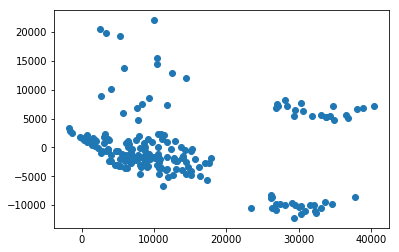

In [29]:
# Calculating the residuals
resi = y_test - y_pred
plt.scatter(y_pred,resi)

As we can see from the plot there is no correlation between the residual term, thus fulfilling the assumption of absence of Autocorrelation in linear regression.

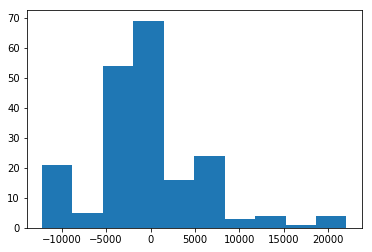

In [30]:
_ = plt.hist(resi)

As we can see from the graph that the residuals are not perfectly normally distributed, thus violating one of the assumption of linear regression.

In [31]:
from sklearn.linear_model import Lasso


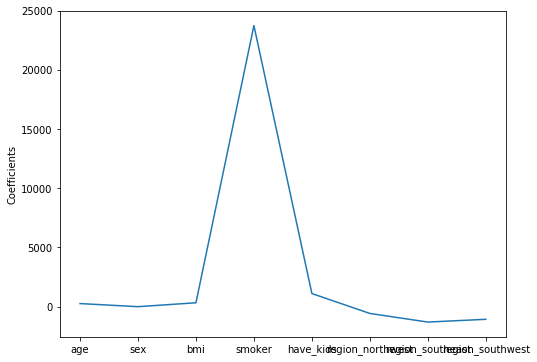

In [32]:
names = df1.drop(['charges'], axis=1).columns

lasso = Lasso(alpha=0.1)

plt.figure(figsize=(8,6))

lasso_coef = lasso.fit(X,y).coef_
plt.plot(range(len(names)), lasso_coef)
plt.xticks(range(len(names)), names)
plt.ylabel("Coefficients")

plt.show()

The graph tells us that "smoker" is the most important feature of our model

### 9. If a hospital was looking to minimize its cost, what population should it target based on your analysis?

In [33]:
ages = pd.DataFrame(df['age'], columns=['age'])

In [34]:
bins = [18, 30, 40, 50, 60, 70]
labels = ['18-30', '31-40', '41-50', '51-60', '61+']       

In [35]:
ages['agerange'] = pd.cut(ages.age, bins, labels = labels,include_lowest = True)

In [36]:
ages.head()

,age,agerange
0,45,41-50
1,36,31-40
2,64,61+
3,46,41-50
4,19,18-30


In [37]:
df['age_range'] = (ages['agerange'])

In [38]:
bmis = pd.DataFrame(df['bmi'], columns=['bmi'])

In [39]:
bins_bmi = [15, 20, 30, 40, 50, 60]
labels_bmi = ['15-19', '20-29', '30-39', '40-49', '50+'] 

In [40]:
bmis['bmi_range'] = pd.cut(bmis.bmi, bins_bmi, labels = labels_bmi,include_lowest = True)

In [41]:
bmis.head()

,bmi,bmi_range
0,25.175,20-29
1,30.020,30-39
2,26.885,20-29
3,25.745,20-29
4,31.920,30-39


In [42]:
df['bmi_range'] = (bmis['bmi_range'])

In [43]:
df.head(20)

,age,sex,bmi,smoker,region,charges,have_kids,age_range,bmi_range
0,45,0,25.175,0,northeast,9095.06825,1,41-50,20-29
1,36,0,30.020,0,northwest,5272.17580,0,31-40,30-39
2,64,0,26.885,1,northwest,29330.98315,0,61+,20-29
3,46,1,25.745,0,northwest,9301.89355,1,41-50,20-29
4,19,1,31.920,1,northwest,33750.29180,0,18-30,30-39
5,34,1,42.900,0,southwest,4536.25900,1,31-40,40-49
6,19,0,22.515,0,northwest,2117.33885,0,18-30,20-29
7,64,1,37.905,0,northwest,14210.53595,0,61+,30-39
8,28,0,17.290,0,northeast,3732.62510,0,18-30,15-19
9,49,1,28.690,0,northwest,10264.44210,1,41-50,20-29


In [44]:
target_pop = df.groupby(['age_range','bmi_range','smoker'])['charges'].mean()
target_pop = pd.DataFrame(target_pop)

In [45]:
target_pop.head()

charges
age_range bmi_range smoker              
18-30     15-19     0        4465.159918
                    1       14097.226200
          20-29     0        4312.694089
                    1       17432.228992
          30-39     0        4700.572922

In [46]:
 target_pop.reset_index(level=0, inplace = True)

In [47]:
 target_pop.reset_index(level=0, inplace = True)

In [48]:
 target_pop.reset_index(level=0, inplace = True)

In [49]:
target_pop = target_pop.sort_values('charges')

In [50]:
target_pop.head(20)

,smoker,bmi_range,age_range,charges
8,0,50+,18-30,1800.758950
6,0,40-49,18-30,3605.178305
2,0,20-29,18-30,4312.694089
0,0,15-19,18-30,4465.159918
4,0,30-39,18-30,4700.572922
10,0,15-19,31-40,6470.355250
12,0,20-29,31-40,6624.380177
14,0,30-39,31-40,6651.465885
16,0,40-49,31-40,7040.778786
18,0,15-19,41-50,8444.038838


**target_pop** dataframe can be used by the hospital to decide on the type of population it should use to minimize it's cost.

### 10. A Co-worker asks you whether you should use AIC, BIC, or R-squared to evaluate one model over another. Explain to them (in layman's terms) each of these metrics and why you should use one over the other.

Adjusted R-Squared is a version of R-Squared that adjusted for the number of predictors (independent variables) in a model. This Adjusted R-Squared has an advantage over the normal R-Squared metric because it accounts for statistical shrinkage and the normal R-Squared metric tends to hurt more when more independent variables occur in the system.
The AIC (Akaike Information Criterion) Metric describes the quality of the model with the data that is given. AIC is applicable in a broad range of modeling frameworks as it only requires large sample properties of maximum likelihood estimator. It uses candidate models to manipulate the data but does not require the assumption that these models will be true or correct. AIC is the trade-off between goodness of fit and complexity of the variables that are considered in the problem. R-Squared changes relative to the complexity of the system (variables) but AIC does not. 
The BIC (Bayesian Information Criterion) is closely related to AIC except for it uses a Bayesian (probability) argument to figure out the goodness to fit. It also has the same advantage over the R-Squared metric in that complex problems are less impacted with AIC or BIC vs. R-Squared method.

### 11. If this was a time-series panel as opposed to cross-sectional data, how would you have changed your model?

As we know that Time-series data is a set of observations collected at usually discrete and equally spaced time intervals and Cross-sectional data are observations that come from different individuals or groups at a single point in time.<br><br>
So the way I'll change my model is by incorporating the target variable "charges" as a feature and taking a lot of time steps to check if the "charges" have changed over time.

### 12. Your boss comes to you and says we wants to limit patients that may cost more than 50K. You don't need to write code to do this, but outline how you could create a model that would take a new patient's characteristics and output the probability that their medical charges would be over 50K.<br>
### How would you evaluate the effectiveness of your model?<br>
### Once your boss gets your model, he/she sees that your model outputs probabilities. He/She then asks you what probability cut-off should we use to exclude patients (ie if prob is above X, we exclude them. Tell us what X should be)

I would bulid a classification model to limit the patients that may cost more than 50K <br>
With the target variable = 1 if the cost is > 50k and 0 if the cost is < 50k <br>
I would use Logistic Regression as my model to get the probabilities of the getting the target = 1 <br>
I would use **Precision = True Positives / True Positives + False Postives** as the metric to evaluate the effectiveness of the model <br>
For the probability of the cut-off I would form a Receiver Operating Characteristics (ROC) curve to get all the thressholds and select the cut-off will would maximize my precision without increasing my False Positive rate a lot. 
